# Analysis of MD trajectories of RNA oligomers

In [1]:
import os, pandas, pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## First part - from `DATA_structures`

Focus on distances between $C5$ atoms in the nucleobases and on possible formation of Hydrogen bonds (data in `DATA_structures` directory, see also `README.md` file).

After the analysis in this notebook we will conclude that:
- stacking is the driving force in these RNA oligomers;
- there are several conformational structures, depending on which nucleobases stack on which (the most common structure is all the 4 nucleobases stacked on each other 1-2-3-4, but also stacking with couples is possible);
- these oligomers are not too small to have Hydrogen bond formation (including Watson-Crick pairings? **remember**: Watson-Crick pairings are only between A-U and G-C; in principle, you could also have non-canonical base pairing A-A due to hydrogen bonds, as it might happen in AAAA oligomers, but I don't see it), still only in some oligomers and for a limited number of frames in the MD trajectory;
- see also paper ***Conformational ensembles of RNA oligonucleotides from integrating
NMR and molecular simulations*** by Bottaro, Bussi et al.

The cluster analysis may be extended to a Markov State Model, deriving transition paths and rates between clusters (critical issue: starting MD simulations were performed with REST - replica exchange solute tempering).

Moreover, the H-bonds can be analyzed also in relation with clusters.

Then, you can extract images illustrating these different conformations (including the formation of Hydrogen bonds, either Watson-Crick or non-canonical).

Which are the transient states between different clusters? Note that you make a (slight) mistake on frames corresponding to transitions between different clustered configurations (they should not belong to any cluster, is it right?)

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 1. analyse distances between nucleobases

In [3]:
with open('DATA_structures/n_frames.pickle', 'rb') as my_pickle:
    n_frames = pickle.load(my_pickle)

n_frames

{'AAAA': [85001, 200001, 250001, 126001, 356001],
 'CCCC': [72001, 188001, 200001, 110001, 98001, 340001],
 'CAAU': [90001, 166001, 200001, 118001, 100001, 330001],
 'GACC': [72001, 188001, 196001, 110001, 100001, 100001, 248001],
 'UUUU': [84001, 160001, 200001, 118001, 100001, 98001, 244001],
 'UCAAUC': [72001, 172001, 200001, 112001, 100001, 356001],
 'UCUCGU': [90001, 200001, 200001, 200001, 310001]}

In [4]:
names = ['1-2', '1-3', '1-4', '2-3', '2-4', '3-4']  # for tetramers
names_hexa = ['%i-%i' % (j + 1, i + 1) for j in range(6) for i in range(j + 1, 6)]  # for hexamers

In [5]:
sequences = ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC', 'UCUCGU']

In [6]:
# distances = np.load('../DATA_structures/%s_distances_0.npy' % sequence)
distances = {}

for sequence in sequences:
    distances[sequence] = []

    my_list = os.listdir('DATA_structures')
    my_list = [s for s in my_list if s.startswith('%s_distances' % sequence)]

    for i in range(len(my_list)):
        """ load and skip the first frame of each subtrajectory, to be consistent with the observables """
        distances[sequence].append(np.load('DATA_structures/%s_distances_%i.npy' % (sequence, i))[1:, :])

""" remove distances between an atom and itself (computed by mistake) """
for i in range(2): distances['AAAA'][i] = distances['AAAA'][i][:, [1, 2, 3, 5, 6, 8]]
# np.save('DATA_structures/distances.npy', distances)

""" correctly sort distances lists by comparing n. of frames in distances lists and n_frames.pickle
    (I forgot to sort subtrajs for AAAA and CAAU) """

# print([distances['AAAA'][i].shape for i in range(len(distances['AAAA']))])
# print(n_frames['AAAA'])

distances['AAAA'][:] = [distances['AAAA'][i] for i in [2, 0, 3, 1, 4]]
distances['CAAU'][:] = [distances['CAAU'][i] for i in [1, 5, 2, 4, 0, 3]]

for s in sequences: distances[s] = np.concatenate((distances[s]))

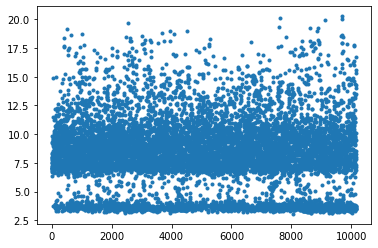

In [7]:
plt.plot(distances['AAAA'][:, 1][::100], '.')

1-3


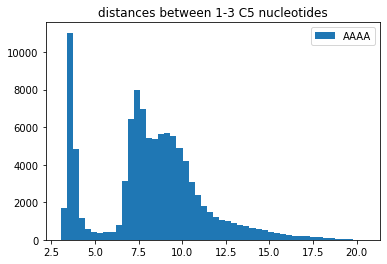

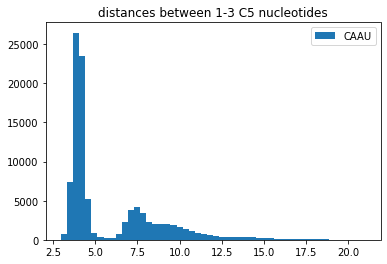

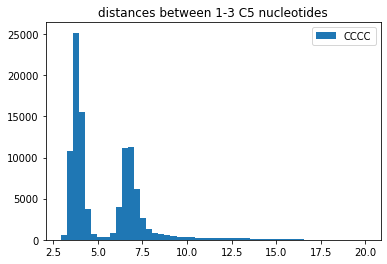

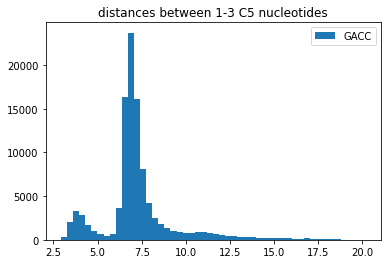

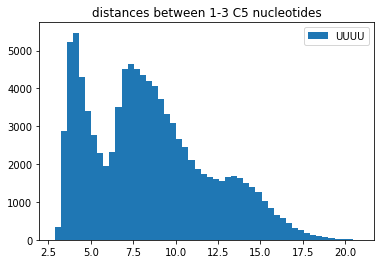

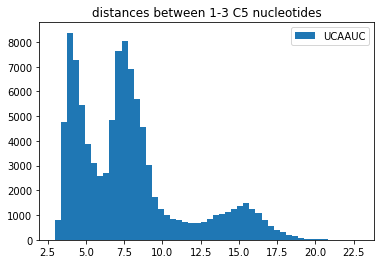

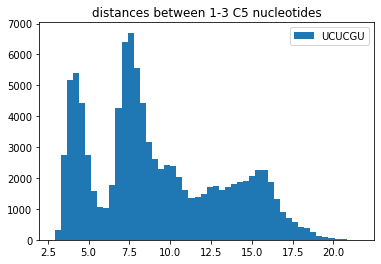

In [8]:
i = 1
print(names[i])

for sequence in sequences:
    plt.figure()
    plt.hist(distances[sequence][:, i][::10], bins=50, label=sequence)  # , alpha=0.75)
    plt.title('distances between %s C5 nucleotides' % names[i])

    plt.legend()

- use as indices the numbers of frames so that when you remove some frames (e.g. by skipping first frame of each subtrajectory or with a stride) you still know to which frame the distances correspond to (in this way, you can go back to the subtrajectory and visualize the structure and also compare with `hbonds`)

In [9]:
for sequence in sequences:

    my_frames = [0] + list(np.cumsum(n_frames[sequence]))

    inds = np.delete(np.arange(my_frames[-1]), my_frames[:-1])

    df = pandas.DataFrame(distances[sequence])
    df.index = inds
    df.index.name = 'n frames'

    distances[sequence] = df

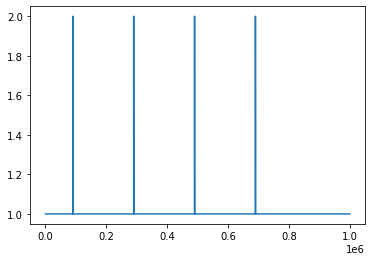

In [10]:
plt.plot(np.ediff1d(inds))

#### fix a molecular system `sequence`, and use `dists = distances[sequence]`

notice that `dists` is a pandas dataframe with row indices corresponding to number of frames

In [11]:
sequence = 'UUUU'
dists = distances[sequence]

In [12]:
dists.shape

(1004000, 6)

##### which is the optimal n. of clusters?

In [13]:
stride = 100

score_list = []

for n_clusters in range(2, 20):
    print('n. clusters: ', n_clusters)

    km = KMeans(n_clusters=n_clusters)
    labels = km.fit_predict(dists[::stride])
    score_list.append(silhouette_score(dists[::stride], labels))

print(score_list)

n. clusters:  2
n. clusters:  3
n. clusters:  4
n. clusters:  5
n. clusters:  6
n. clusters:  7
n. clusters:  8
n. clusters:  9
n. clusters:  10
n. clusters:  11
n. clusters:  12
n. clusters:  13
n. clusters:  14
n. clusters:  15
n. clusters:  16
n. clusters:  17
n. clusters:  18
n. clusters:  19
[0.33226207, 0.37088698, 0.4157782, 0.38896707, 0.40008992, 0.40959683, 0.4045073, 0.3506584, 0.36022255, 0.3618628, 0.34608892, 0.32110304, 0.32706577, 0.26935068, 0.27570102, 0.2732873, 0.27322856, 0.27354404]


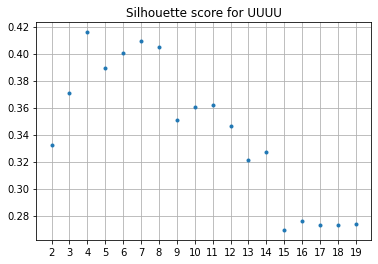

In [14]:
plt.plot(np.arange(2, 20), score_list, '.')
plt.xticks(np.arange(2, 20))
plt.title('Silhouette score for %s' % sequence)
plt.grid()
plt.show()

so let's take 8 clusters (depending on the system)

##### cluster

[4 4 4 ... 0 6 3] 0.40514642


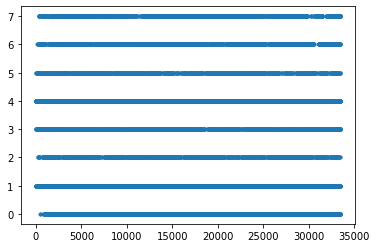

In [15]:
n_clusters = 8
stride = 30

km = KMeans(n_clusters=n_clusters)
labels = km.fit_predict(dists[::stride])
score = silhouette_score(dists[::stride], labels)

print(labels, score)

plt.plot(labels, '.')

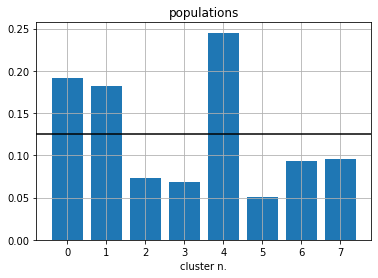

In [16]:
whs = []
pops = []

for i in range(n_clusters):
    wh = np.concatenate(np.argwhere(labels == i))
    whs.append(np.array(dists[::stride].iloc[wh].index))
    pops.append(len(whs[-1]))

pops = pops/np.sum(pops)

plt.title('populations')
plt.xlabel('cluster n.')
plt.bar(np.arange(len(pops)), pops)
plt.xticks(np.arange(len(pops)), np.arange(len(pops)))
plt.grid()
xlims = plt.xlim()
plt.plot(xlims, 1/len(pops)*np.ones(2), '-k')
plt.xlim(xlims)
# plt.yscale('log')
plt.show()

##### visualize the results
- `labels` is the array of cluster labels and `score` is its associated Silhouette score
- `whs` are the frame indices of each cluster
- `pops` is the population of each cluster

so you can plot both at fixed couple of atoms (and different clusters) or at fixed clusters

notice in the first case `density = True` or `False` will change the plot (namely, ratio between peaks) due to different populations of each cluster, while in the second case it will only affect the y-axis

- consider that you performed clustering on an array with a given stride, so the frame indices `whs` are a subset of all the frames; to select corresponding value of `dists`, just select indicated frames `dists.loc[whs[i]]` (without the need for `dists[::stride]`)

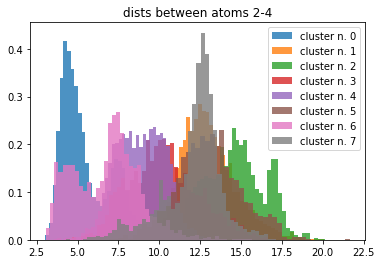

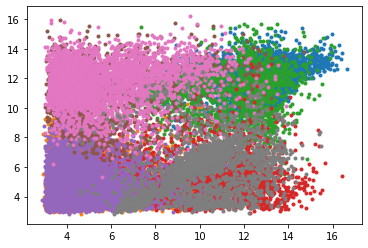

In [17]:
j = 4

for i in range(n_clusters):
    plt.hist(dists.loc[whs[i]].iloc[:, j], bins=50, alpha=0.8, label='cluster n. %i' % i, density=True)
    plt.title('dists between atoms %s' % names[j])
    plt.legend()

plt.figure()
for i in range(n_clusters):
    plt.plot(dists.loc[whs[i]].iloc[:, 0], dists.loc[whs[i]].iloc[:, 3], '.')

ok, now let's focus on a single cluster to see what it is

- require unimodal distributions (single peak for each histogram of each cluster); in this way, you can also compute average distances `avs`, which will be useful in the case of hexamers (namely, when there are so many nucleotides that it becomes challenging to distinguish them by eye)

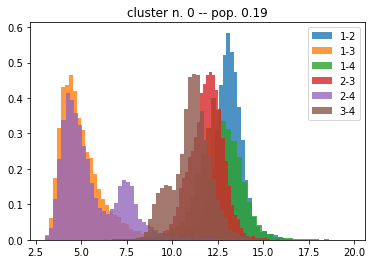

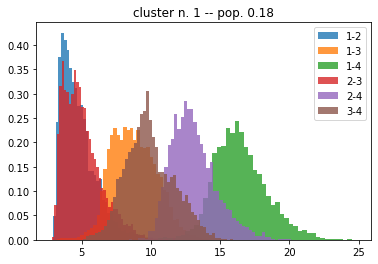

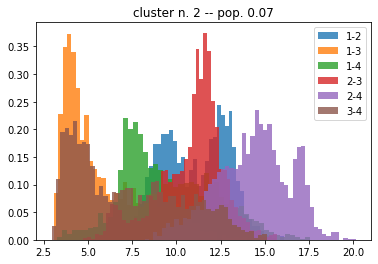

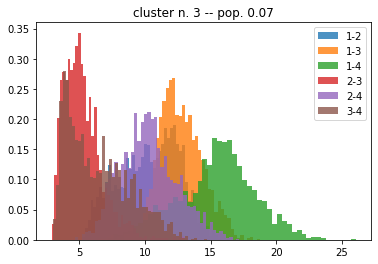

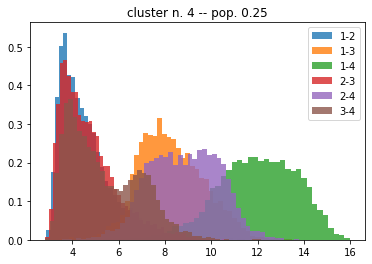

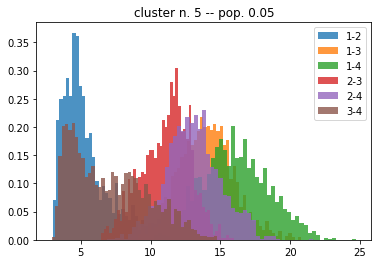

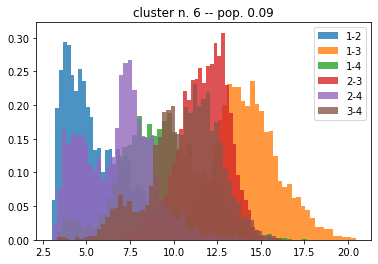

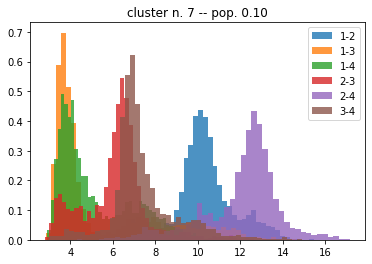

In [18]:
if dists.shape[1] == 15: my_strings = names_hexa  # hexamers
elif dists.shape[1] == 6: my_strings = names  # tetramers

# list of 15 different colors (to avoid repetitions)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']

avs = []
stds = []

for i_cluster in range(n_clusters):
    avs.append([])
    stds.append([])

    plt.figure()
    
    for i in range(dists.shape[1]):
        plt.hist(dists.loc[whs[i_cluster]].iloc[:, i], bins=50, alpha=0.8, label=my_strings[i], density=True, color=colors[i])
        avs[-1].append(np.mean(dists.loc[whs[i_cluster]].iloc[:, i]))
        stds[-1].append(np.std(dists.loc[whs[i_cluster]].iloc[:, i]))

    plt.title('cluster n. %i -- pop. %.2f' % (i_cluster, pops[i_cluster]))
    plt.legend()

In [19]:
# wh = np.where(pops > 1/len(pops))[0]

# most populated clusters, above a thresold
wh = np.argsort(pops)[::-1]
threshold = 1/(2*len(pops))
wh = wh[pops[wh] > threshold]

# or, alternatively, least populated clusters
# wh = np.argsort(pops)[:5]

wh

array([4, 0, 1, 7, 6, 2, 3])

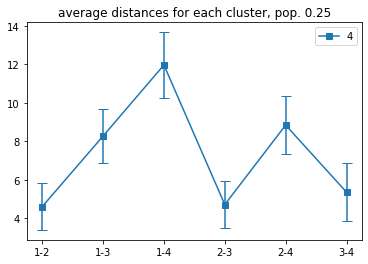

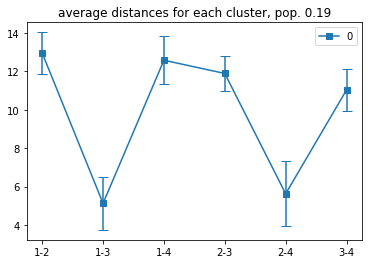

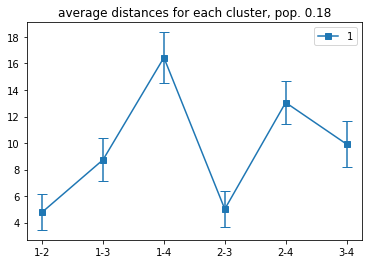

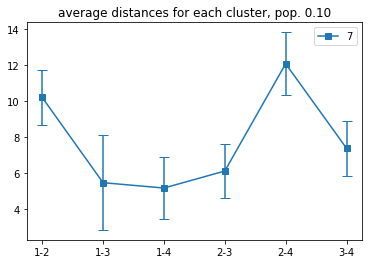

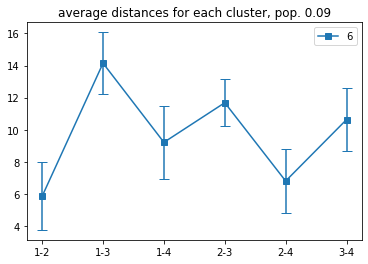

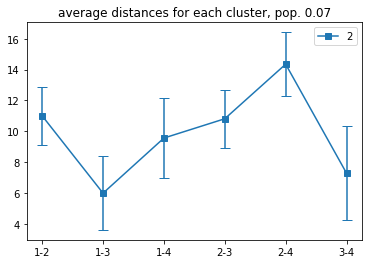

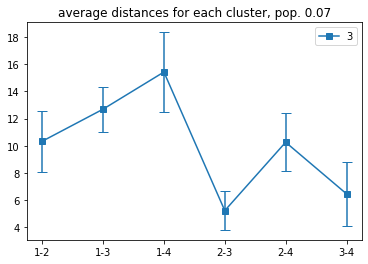

In [20]:
for i_cluster in wh:

    plt.figure()
    plt.plot(avs[i_cluster], 's-', label=i_cluster)
    plt.errorbar(range(len(avs[i_cluster])), avs[i_cluster], yerr=stds[i_cluster], c='tab:blue', linestyle='', capsize=5)

    plt.xticks(range(len(avs[i_cluster])), my_strings)
    # plt.grid()

    plt.title('average distances for each cluster, pop. %.2f' % pops[i_cluster])
    plt.legend()

does this correspond to the clustering on the dihedral angles?

### 2. hydrogen bonds

In [21]:
sequences = ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC', 'UCUCGU']

hbonds = {}

for sequence in sequences:
    my_hbonds = []

    my_list = os.listdir('DATA_structures')
    my_list = [s for s in my_list if s.startswith('%s_Hbonds' % sequence)]
    my_list = np.sort(my_list)

    for s in my_list:
        # load and skip the first frame of each subtrajectory, to be consistent with the observables
        my_hbonds.append(np.load('DATA_structures/' + s))
    
    my_hbonds = np.concatenate((my_hbonds))

    my_hbonds = pandas.DataFrame(my_hbonds)
    my_hbonds.columns = ['frame index', 'donor id', 'hydrogen id', 'acceptor id', 'distance', 'angle']
    for s in ['frame index', 'donor id', 'hydrogen id', 'acceptor id']:
        my_hbonds[s] = np.int64(my_hbonds[s])
    
    hbonds[sequence] = my_hbonds

for s in sequences:
    print(s, hbonds[s], '\n')

AAAA Empty DataFrame
Columns: [frame index, donor id, hydrogen id, acceptor id, distance, angle]
Index: [] 

CAAU     frame index  donor id  hydrogen id  acceptor id  distance       angle
0         22145       114          115           59  2.933207  152.349714
1         83246       114          115           59  3.087606  164.259676
2         83268       114          115           59  3.397384  158.090690
3         32775       114          115           26  3.112269  150.185722
4         50279       114          115           59  2.863877  157.774706
5        125773       114          115           59  3.361233  152.881980
6         74851       114          115           59  3.285315  164.118588
7         74857       114          115           59  3.186847  172.778760
8         74901       114          115           59  3.123157  172.888583
9         74903       114          115           59  2.993729  160.167598
10        74904       114          115           59  2.846084  152.97572

In [22]:
def filter_rows_by_value(df, col, values):
    return df[~df[col].isin(values)]

for s in sequences:
    hbonds[s] = filter_rows_by_value(hbonds[s], 'frame index', [[0] + np.cumsum(n_frames[s])])



In [23]:
hbonds['CAAU']

,frame index,donor id,hydrogen id,acceptor id,distance,angle
0,22145,114,115,59,2.933207,152.349714
1,83246,114,115,59,3.087606,164.259676
2,83268,114,115,59,3.397384,158.090690
3,32775,114,115,26,3.112269,150.185722
4,50279,114,115,59,2.863877,157.774706
5,125773,114,115,59,3.361233,152.881980
6,74851,114,115,59,3.285315,164.118588
7,74857,114,115,59,3.186847,172.778760
8,74901,114,115,59,3.123157,172.888583
9,74903,114,115,59,2.993729,160.167598


I could take the same stride used for `distances`, however, since Hydrogen bonds are formed rarely, this would have a strong impact on the statistics of `hbonds` (for example, some couples donor/acceptor will not be found, as it happens for `UUUU` oligomer with `stride = 10`)

- you could perform clustering on Ulysses supercomputer without imposing a stride on `distances`

In [24]:
stride = 10  # same as for distances

In [25]:
hbonds['UUUU'] = hbonds['UUUU'][np.mod(hbonds['UUUU']['frame index'], stride) == 0]

In [26]:
couples = {}

for s in sequences:
    couples_don_acc = np.vstack((hbonds[s]['donor id'], hbonds[s]['acceptor id']))  # , my_df['hydrogen id']))
    couples[s] = np.unique(couples_don_acc, axis=1)

couples

{'AAAA': array([], shape=(2, 0), dtype=int64),
 'CAAU': array([[114, 114],
        [ 26,  59]]),
 'CCCC': array([], shape=(2, 0), dtype=int64),
 'GACC': array([], shape=(2, 0), dtype=int64),
 'UUUU': array([[ 17,  17,  17,  17,  17,  17,  47,  47,  47,  47,  47,  47,  47,
          77,  77,  77,  77,  77, 107, 107, 107, 107, 107, 107, 107, 107],
        [ 46,  76,  80, 106, 110, 115,  16,  20,  76,  80, 106, 110, 115,
          16,  20,  25,  50, 106,  16,  20,  25,  46,  50,  55,  76,  80]]),
 'UCAAUC': array([[ 17,  17,  17,  17,  17,  17, 144, 144, 144, 144],
        [ 89, 122, 143, 147, 152, 183,  16,  20,  25,  56]]),
 'UCUCGU': array([[ 17,  17,  17,  17,  17,  17,  17,  17,  78,  78,  78,  78,  78,
          78,  78, 173, 173, 173, 173, 173, 173, 173, 173],
        [ 77,  81,  86, 117, 151, 172, 176, 181,  16,  20,  25, 151, 172,
         176, 181,  16,  20,  25,  56,  77,  81,  86, 117]])}

30        77
32        77
63        77
72        77
97        77
        ... 
24065     77
24074    107
24082    107
24104    107
24116     47
Name: donor id, Length: 2370, dtype: int64 30        20
32        20
63        20
72        20
97        20
        ... 
24065    106
24074     50
24082     20
24104     20
24116     76
Name: acceptor id, Length: 2370, dtype: int64

donor/acceptor couples:
 {'AAAA': array([[ 17,  17,  17,  17,  17,  17,  47,  47,  47,  47,  47,  47,  47,
         77,  77,  77,  77,  77, 107, 107, 107, 107, 107, 107, 107, 107],
       [ 46,  76,  80, 106, 110, 115,  16,  20,  76,  80, 106, 110, 115,
         16,  20,  25,  50, 106,  16,  20,  25,  46,  50,  55,  76,  80]]), 'CAAU': array([[ 17,  17,  17,  17,  17,  17,  47,  47,  47,  47,  47,  47,  47,
         77,  77,  77,  77,  77, 107, 107, 107, 107, 107, 107, 107, 107],
       [ 46,  76,  80, 106, 110, 115,  16,  20,  76,  80, 106, 110, 115,
         16,  20,  25,  50, 106,  16,  20,  25,  46,  50,  55,  76

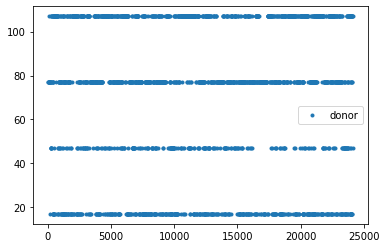

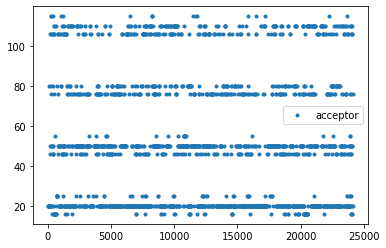

In [27]:
my_df = hbonds['UUUU']

print(my_df['donor id'], my_df['acceptor id'])

couples = {}

for s in sequences:
    couples_don_acc = np.vstack((my_df['donor id'], my_df['acceptor id']))  # , my_df['hydrogen id']))
    couples[s] = np.unique(couples_don_acc, axis=1)

print('\ndonor/acceptor couples:\n', couples)

print('total n. of couples: ', len(couples))

plt.plot(my_df['donor id'], '.', label='donor')
plt.legend()

plt.figure()
plt.plot(my_df['acceptor id'], '.', label='acceptor')
plt.legend()

In [28]:
print(couples)

{'AAAA': array([[ 17,  17,  17,  17,  17,  17,  47,  47,  47,  47,  47,  47,  47,
         77,  77,  77,  77,  77, 107, 107, 107, 107, 107, 107, 107, 107],
       [ 46,  76,  80, 106, 110, 115,  16,  20,  76,  80, 106, 110, 115,
         16,  20,  25,  50, 106,  16,  20,  25,  46,  50,  55,  76,  80]]), 'CAAU': array([[ 17,  17,  17,  17,  17,  17,  47,  47,  47,  47,  47,  47,  47,
         77,  77,  77,  77,  77, 107, 107, 107, 107, 107, 107, 107, 107],
       [ 46,  76,  80, 106, 110, 115,  16,  20,  76,  80, 106, 110, 115,
         16,  20,  25,  50, 106,  16,  20,  25,  46,  50,  55,  76,  80]]), 'CCCC': array([[ 17,  17,  17,  17,  17,  17,  47,  47,  47,  47,  47,  47,  47,
         77,  77,  77,  77,  77, 107, 107, 107, 107, 107, 107, 107, 107],
       [ 46,  76,  80, 106, 110, 115,  16,  20,  76,  80, 106, 110, 115,
         16,  20,  25,  50, 106,  16,  20,  25,  46,  50,  55,  76,  80]]), 'GACC': array([[ 17,  17,  17,  17,  17,  17,  47,  47,  47,  47,  47,  47,  47,
      

In [29]:
import MDAnalysis as mda

/usr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
mol_name = 'UUUU'
univ = mda.Universe('DATA_structures/reference_test_%s.pdb' % mol_name)

# for i in range(couples[:, 0].shape[1]):
#     print('couple: donor %s with acceptor %s' % (univ.atoms[couples[0, i]], univ.atoms[couples[1, i]]), '\n')

for i in np.unique(couples[mol_name][0]):
    print('donor %s' % univ.atoms[i])

for i in np.unique(couples[mol_name][1]):
    print('acceptor %s' % univ.atoms[i])

donor <Atom 18: N3 of type N of resname U, resid 1 and segid SYSTEM and altLoc >
donor <Atom 48: N3 of type N of resname U, resid 2 and segid SYSTEM and altLoc >
donor <Atom 78: N3 of type N of resname U, resid 3 and segid SYSTEM and altLoc >
donor <Atom 108: N3 of type N of resname U, resid 4 and segid SYSTEM and altLoc >
acceptor <Atom 17: O4 of type O of resname U, resid 1 and segid SYSTEM and altLoc >
acceptor <Atom 21: O2 of type O of resname U, resid 1 and segid SYSTEM and altLoc >
acceptor <Atom 26: O2' of type O of resname U, resid 1 and segid SYSTEM and altLoc >
acceptor <Atom 47: O4 of type O of resname U, resid 2 and segid SYSTEM and altLoc >
acceptor <Atom 51: O2 of type O of resname U, resid 2 and segid SYSTEM and altLoc >
acceptor <Atom 56: O2' of type O of resname U, resid 2 and segid SYSTEM and altLoc >
acceptor <Atom 77: O4 of type O of resname U, resid 3 and segid SYSTEM and altLoc >
acceptor <Atom 81: O2 of type O of resname U, resid 3 and segid SYSTEM and altLoc >
a

## Second part: from `Zenodo`

it requires to install `MDRefine`

### 3. load data

In [31]:
import sys, jax.numpy as jnp

In [32]:
!pip install MDRefine

Defaulting to user installation because normal site-packages is not writeable


In [33]:
sys.path.insert(0, '../')

import MDRefine

from MDRefine import load_data

In [34]:
%%bash

if [ ! -d "DATA" ]; then
    echo "download DATA from Zenodo"
    curl -O https://zenodo.org/records/14956459/files/DATA.zip

    unzip DATA.zip
    rm -r DATA.zip
fi

In [35]:
infos = {'global': {
    # 'path_directory': 'MDRefine/MDRefine/tests/DATA_test',
    # DATA_test corresponds to stride = 1e4 and only one observable per type
    
    'path_directory': '../DATA/',
    
    'system_names': ['AAAA'],  # , 'CAAU'],  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs' , ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon', 'sugar'],
    'obs': ['NOEs', 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 1

In [36]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [37]:
infos['global']['forward_model'] = forward_model_fun

In [38]:
infos['global']['names_ff_pars'] = ['sin alpha']  # , 'cos alpha']

def ff_correction(pars, f):
    # out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    out = jnp.matmul(pars, (f[:, [0]] + f[:, [1]] + f[:, [2]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
# infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [39]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
done


### 4. analyse `forward_qs` (dihedral angles)

In [40]:
stride = 100
qs = data.mol['AAAA'].forward_qs['backbone1_gamma'][::stride]

qs.shape

(10170, 8)

(-3.141592653589793, 3.141592653589793)

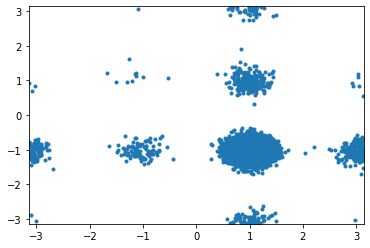

In [41]:
plt.plot(qs[:, 3], qs[:, 4], '.')
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

it is not a good choice to do clustering on angles, due to periodicity $\pm \pi$, so let's take sin and cos

then, sort columns such the new cols 0 and 1 corresponds sin/cos of the same angle, and so on 

In [42]:
vals = np.hstack((np.cos(qs), np.sin(qs)))

l = qs.shape[1]
my_list = [[i, l + i] for i in range(l)]
my_list = [i2 for i in my_list for i2 in i]
print(my_list)

vals = vals[:, my_list]

[0, 8, 1, 9, 2, 10, 3, 11, 4, 12, 5, 13, 6, 14, 7, 15]


[1 1 1 ... 1 1 1] 0.6367538


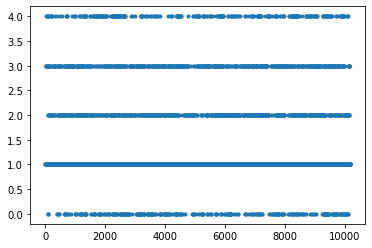

In [43]:
n_clusters = 5
km = KMeans(n_clusters=n_clusters)
labels = km.fit_predict(vals)
score = silhouette_score(vals, labels)

print(labels, score)

plt.plot(labels, '.')

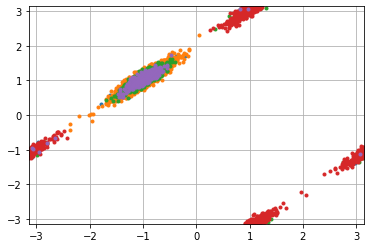

In [44]:
for i in range(n_clusters):
    wh = np.argwhere(labels == i)
    plt.plot(qs[:, 0][wh], qs[:, 1][wh], '.')

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.grid()

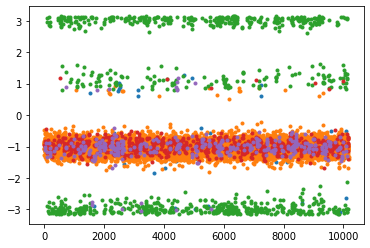

In [45]:
for i in range(n_clusters):
    wh = np.argwhere(labels == i)
    plt.plot(wh, qs[:, 6][wh], '.')

- focus on each cluster

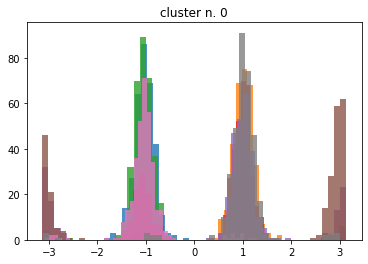

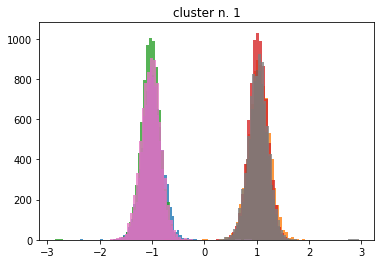

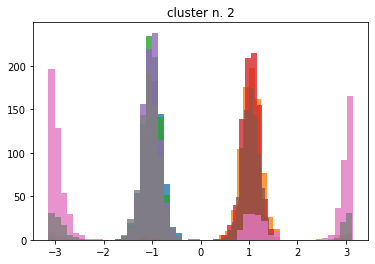

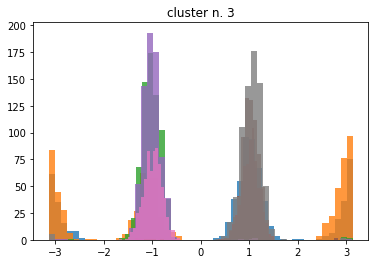

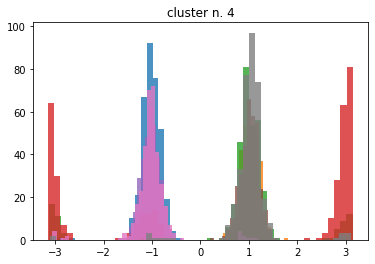

In [46]:
for i_cluster in range(n_clusters):
    plt.figure()
    plt.title('cluster n. %i' % i_cluster)
    
    wh = np.argwhere(labels == i_cluster)

    for i in range(qs.shape[1]):
        plt.hist(np.concatenate(qs[wh, i]), bins=50, alpha=0.8)

#### extrapolate to different observables

(10170, 9)


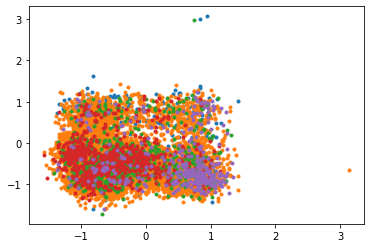

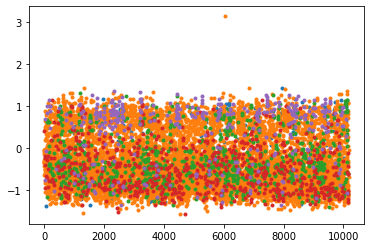

In [47]:
new_qs = data.mol['AAAA'].forward_qs['backbone2_beta_epsilon'][::stride]

print(new_qs.shape)

for i_cluster in range(n_clusters):
    wh = np.argwhere(labels == i_cluster)
    plt.plot(new_qs[wh, 0], new_qs[wh, 3], '.')

plt.figure()
for i_cluster in range(n_clusters):
    wh = np.argwhere(labels == i_cluster)
    plt.plot(wh, new_qs[wh, 0], '.')

#### 1st question: few dihedral angles
if I cluster only on the first n angles, do I get results compatible with clustering over all the dihedral angles in `forward_qs`?

- keep the same `n_clusters = 5`

In [48]:
km = KMeans(n_clusters=5)

labels_list = []
score_list = []

for i in range(1, qs.shape[1] + 1):
    print('n. angles: ', i)
    labels_list.append(km.fit_predict(vals[:, :2*i]))
    score_list.append(silhouette_score(vals[:, :2*i], labels_list[-1]))


n. angles:  1
n. angles:  2
n. angles:  3
n. angles:  4
n. angles:  5
n. angles:  6
n. angles:  7
n. angles:  8


score list, 2 clusters

[0.8336696,
 0.8287808,
 0.75929695,
 0.7230578,
 0.6764616,
 0.6501549,
 0.5788846,
 0.5638173]

score list, 5 clusters

[0.5473917,
 0.46993312,
 0.38838285,
 0.33315068,
 0.67917293,
 0.7191754,
 0.5820661,
 0.6367538]

score list, 8 clusters

 [0.5230222,
 0.40517694,
 0.35218537,
 0.33036307,
 0.28405845,
 0.2785803,
 0.2505651,
 0.24108663]

score list, 10 clusters

[0.51665735,
 0.3690321,
 0.32744792,
 0.3121795,
 0.27988157,
 0.26618728,
 0.27303275,
 0.24165085]

so the optimal is about 5 clusters

In [49]:
how_many = {}
wh = {}

for i_cluster in range(n_clusters):
    how_many[i_cluster] = {}
    wh[i_cluster] = {}
    for n_angle, labels in enumerate(labels_list):
        wh[i_cluster][n_angle] = np.argwhere(labels == i_cluster)
        how_many[i_cluster][n_angle] = len(wh[i_cluster][n_angle])

how_many

{0: {0: 2303, 1: 2598, 2: 377, 3: 4573, 4: 8679, 5: 369, 6: 7907, 7: 7915},
 1: {0: 471, 1: 316, 2: 4635, 3: 314, 4: 378, 5: 469, 6: 363, 7: 350},
 2: {0: 317, 1: 472, 2: 4370, 3: 471, 4: 471, 5: 8680, 6: 754, 7: 863},
 3: {0: 2599, 1: 2374, 2: 316, 3: 383, 4: 316, 5: 314, 6: 350, 7: 700},
 4: {0: 4480, 1: 4410, 2: 472, 3: 4429, 4: 326, 5: 338, 6: 796, 7: 342}}

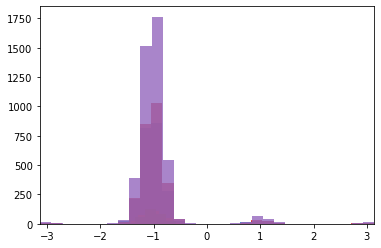

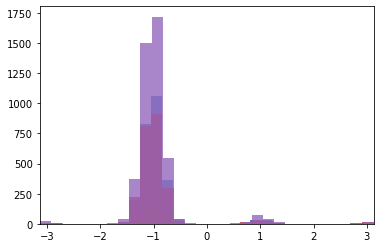

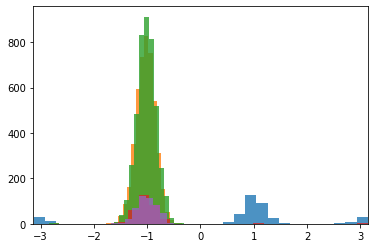

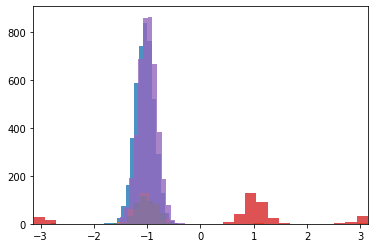

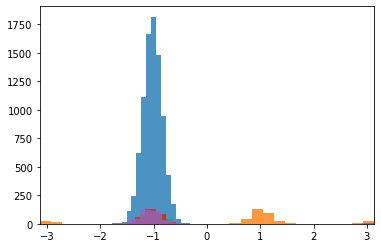

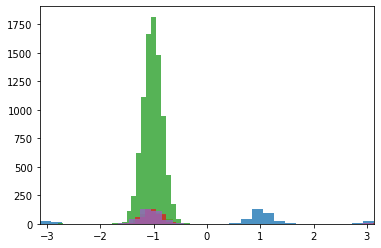

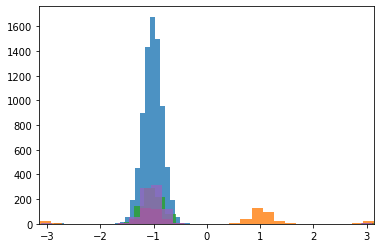

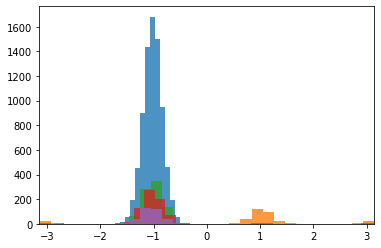

In [50]:
for j in range(8):
    plt.figure()

    for i in range(5):
        plt.hist(np.concatenate(qs[:, 2][wh[i][j]]), alpha=0.8, bins=30)  # , density=True)

    plt.xlim([-np.pi, np.pi])

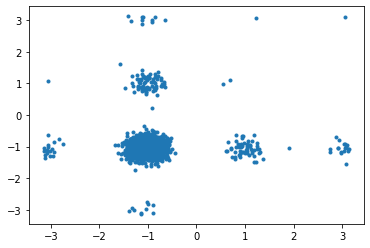

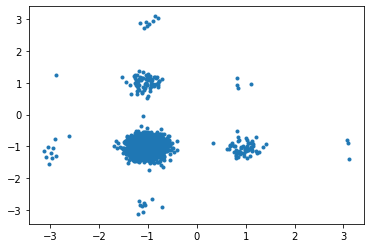

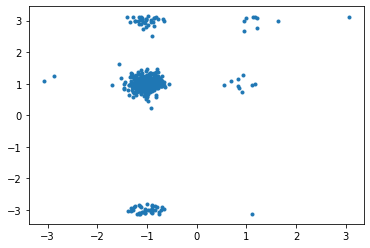

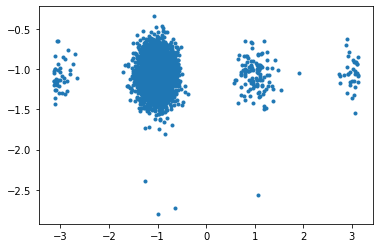

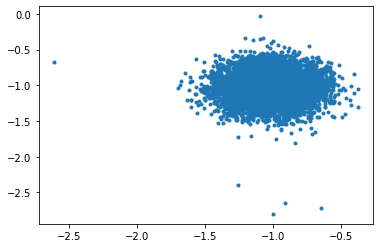

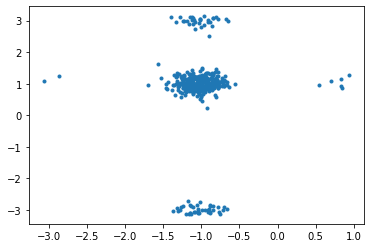

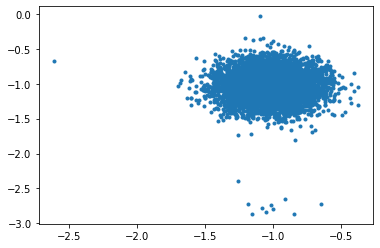

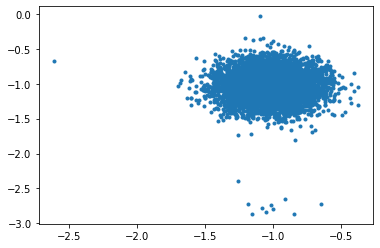

In [51]:
i_cluster = 0

for labels in labels_list:
    wh = np.argwhere(labels == i_cluster)
    plt.figure()
    plt.plot(qs[:, 4][wh], qs[:, 2][wh], '.')

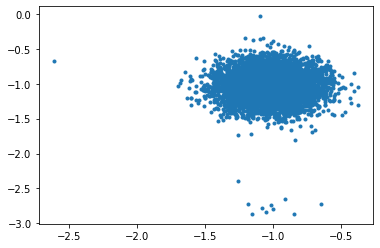

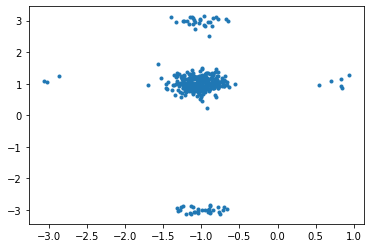

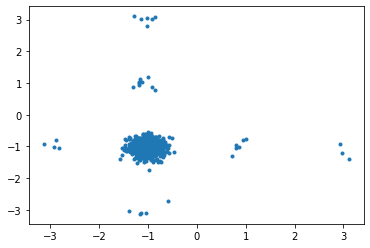

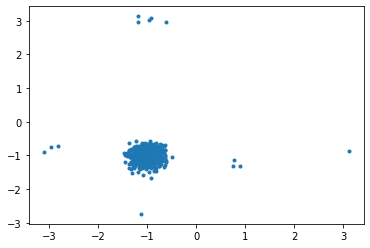

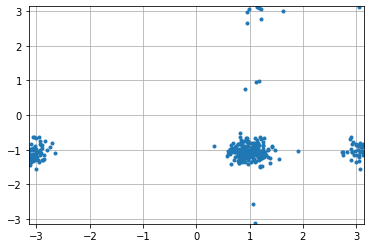

In [52]:
for i in range(n_clusters):
    plt.figure()
    wh = np.argwhere(labels == i)
    plt.plot(qs[:, 4][wh], qs[:, 2][wh], '.')

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.grid()

### 5. plot the experimental observables

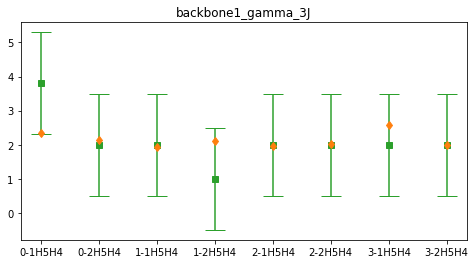

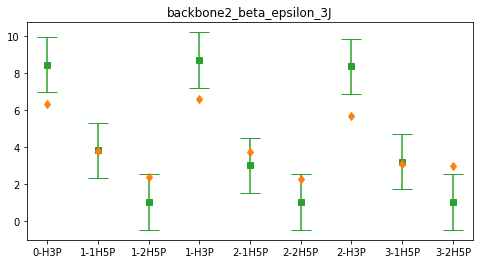

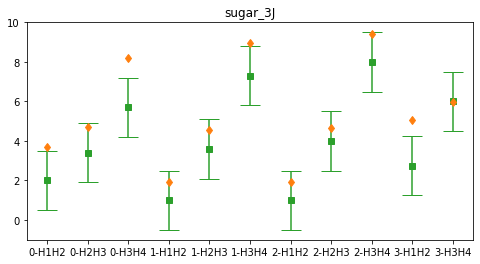

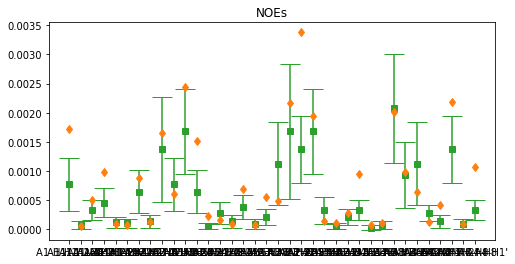

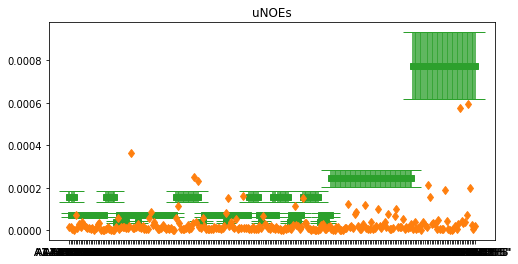

In [53]:
for s in data.mol['AAAA'].gexp.keys():
    
    g_exp = data.mol['AAAA'].gexp[s]

    g = data.mol['AAAA'].g[s]
    g_mean = np.mean(g, axis=0)
    
    plt.figure(figsize=(8, 4))
    plt.title(s)
    
    plt.plot(g_exp[:, 0], 's', c='tab:green')
    plt.errorbar(np.arange(g_exp.shape[0]), g_exp[:, 0], yerr=g_exp[:, 1], linestyle='', capsize=10., c='tab:green')

    plt.plot(g_mean, 'd', c='tab:orange')

    names = np.array([" ".join(row) for row in data.mol['AAAA'].names[s]])  # since two columns for NOEs values
    plt.xticks(np.arange(len(g_mean)), labels=names)